<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/01ZLMA_ex08_binary_data_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 08 of the course 01ZLMA.

# GLM for Discrete response - Binary Data Analysis (02)

Alternative and Binomial responses

**Bernoulli (Alternative) Model**

$$Y_{i,j} \sim Be(\pi_i) \ i = 1,\ldots,K \ \text{and} \ j = 1,\ldots, n_i.$$
$K$ is number of groups, $n_i$ is number of observations in group $i$ and $\sum_{i=1}^{K} = N$
$$ E[Y_{i,j}] = \pi_i \ \text{and} \ g(\pi_i) = \eta_i =x_i^T \beta $$


**Binomial Model**
$$Y_i = \sum_{j=1}^{n_i} Y_{i,j} \sim Bi(n_i, \pi_i)$$

**Without continuos covariate (only factor variables)**

$K$ is constant and $n_i \rightarrow \infty $

**With at least one continuos covariate**

$n_i \approx 1$ ( $n_i$ is small enough) and $K \rightarrow \infty$



## Link functions for binary data

**Logistic function:**

The logistic function is the canonical link function for binary responses, and it is CDF of the standard logistic distribution.

$$\pi_i = \frac{1}{1+e^{-x_i^T \beta}} $$


**Probit function:**

The CDF of the normal distribution.
$$\pi_i = \Phi({x_i^T \beta}) $$


**Cauchit function:**

The CDF of the Cauchy distribution

$$\pi_i = \frac{1}{\pi}\text{arctan}(x_i^T \beta) + \frac{1}{2} $$


**Complementary log-log (cloglog) function:**

The inverse of the conditional log-log function (CDF of the Gumbel distribution)

$$\pi_i = 1 − e^{-e^{x_i^T \beta}}$$

The counter part of the cloglog function is log-log link function.

In [ ]:
import numpy as np
import scipy
from scipy import stats
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_curve, \
     roc_auc_score


import matplotlib.pyplot as plt

from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence

import seaborn as sns
sns.set_theme()

In [ ]:
!pip install dfply
from dfply import *  # handy module to mimic R dplyr library



In [ ]:
# Please note that this cell works may not work in other env-s that Google Colab
!pip install wget
import wget
url = "https://github.com/francji1/01ZLMA/raw/main/code/helpers.py"
wget.download(url, '../content/helpers.py')  # path where Colab can find libraries

In [ ]:
from helpers import DiagnosticPlots ,Anova

In [ ]:
x = np.tile(np.linspace(-5, 5, 101), 4).reshape(4, -1)
y = []
names =[]

for i, j in enumerate(zip(("logit", "probit", "cauchit", "cloglog"),
                (sm.genmod.families.links.Logit(), sm.genmod.families.links.probit(),
                 sm.genmod.families.links.cauchy(), sm.genmod.families.links.CLogLog()))):

    y.append(j[1].inverse(x[i]))
    names.append([j[0]]*len(x[i]))

y = np.array(y).flatten()
n = np.array(names).flatten()

fig, ax = plt.subplots()



sns.lineplot(x='x', y='y', data=pd.DataFrame(data={'x': x.flatten(), 'y': y, 'n': n}), ax=ax, hue='n')


ax.legend()
ax.set_xlabel(r'$x_i^T \beta$')
ax.set_ylabel(r'$\pi_i$')
plt.show()

## Logistic regression with Titanic dataset

https://www.kaggle.com/c/titanic/data

| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

In [ ]:
X, y = datasets.fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

titanic_train = pd.concat([X_train, y_train], axis=1)
titanic_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
titanic_test.describe(include = 'all')

# Fast and furios solution of the HW from the previous Ex07

Consider a model with continuos variables `age`, `fare`, and any factor variable.

* Create factor `age`, which takes values 1 (child) and 0 (adult).
* Create factor from varaible `fare` by spliting into 10 groups with approx same number of observations.
* What percentage is the chance of survival lower for adult compare to child?
* Depends the probability of survival on fare? Test it.
* Assume that the chance of survival increases with exponential increasig fare. How the chance of survival increased if the person spent an extra 10 pound for a ticket?
* Build a model where the probabilty of survival depends on both `age` and `fare`. Are both covariates significant?
*

In [ ]:
data_HW = titanic_train >> \
  select(titanic_train.survived,titanic_train.age,titanic_train.fare,titanic_train.pclass,titanic_train.sex,
         titanic_train.embarked)

data_HW = data_HW.apply(lambda x: x.astype('category') if str(x.dtype) == 'str' else x)
#print(data_HW.describe(include='all'))
#print(data_HW.dtypes)

data_HW = data_HW >> \
            filter_by(data_HW.embarked.isin(('C', 'S', 'Q')) )  >> \
            transmute(survived = data_HW.survived.astype('category'),
                      survived_num = data_HW.survived.astype('float'),
                      age = pd.cut(data_HW.age,(-np.inf, 16, np.inf), labels=["child","adult"]),
                      age_num = data_HW.age,
                      fare = data_HW.fare,
                      fare_quantile = pd.qcut(data_HW.fare, q=8, labels=list(range(1, 9))),
                      fare_quantile2 = pd.qcut(data_HW.fare, q=np.linspace(0, 1, 7)),
                      class_ = data_HW.pclass.astype('category'),
                      sex = data_HW.sex.astype('category'),
                      embarked = data_HW.embarked.astype('category'))

# Create binary (int64) age factor: 1 if child, 0 if adult
data_HW['age_binary'] = np.where(data_HW['age'] == 'child', 1, 0)

# Create fare (float64) by splitting into 8 groups with approx equal observations
data_HW['fare_group'] = pd.qcut(data_HW['fare'], 8, labels=False)

data_HW = data_HW.dropna(axis=0, how='any')  # `axis=0` stands for per index (row)

# Check Dtypes
print(data_HW.info())

data_HW.describe(include='all')


In [ ]:
# Simple Logistic Regression model with all discrete covariates fare,sex, agewithout interactions
mod_HW1=smf.glm(formula = 'survived_num~age+sex+fare_quantile2', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW1.summary())

In [ ]:
#Function to estimate OR with lower and upper limit of 95% CI for OR

def OR_coef(variable,model,CI):
    param = np.array(model.params)
    where = np.where(np.array(model.params.index) == variable)
    beta = param[where]
    se = np.sqrt(np.diag(model.cov_params().to_numpy()))[where]
    or_ = np.exp(beta)

    return pd.DataFrame(index=[variable], data={'OR': or_, 'LCL': np.exp(beta-1*scipy.stats.norm.ppf(CI/2 +0.5)*se)
                                              , 'UCL':np.exp(beta+ scipy.stats.norm.ppf(CI/2 +0.5)*se)})
OR_coef("age[T.adult]",mod_HW1,0.95)

The chances of drowning were almost twice as high in the group of adults as in the group of children.

In [ ]:
# Check model with factorized Fare
mod_HW0=smf.glm(formula = 'survived_num~age+sex', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()
mod_HW1=smf.glm(formula = 'survived_num~age+sex+fare_quantile2', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()
mod_HW2=smf.glm(formula = 'survived_num~age+sex+fare', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW1.summary())



Yes, covariate `fare` is statisticaly significant in the model. But it's better to test it with Deviation test (LRT) compare to Wald tests from summary() function.

In [ ]:
anova = Anova()
anova(mod_HW1,mod_HW0,test="Chisq")

Confirmed.

In [ ]:
# Fare as continuous variable

mod_HW3 = smf.glm(formula = 'survived_num~np.divide(fare, 10)', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()
mod_HW4 = smf.glm(formula = 'survived_num~np.divide(fare, 10)+sex+age', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW4.summary())
print("mod_HW3 ---------")
print(np.exp(mod_HW3.params))
print("mod_HW4 ---------")
print(np.exp(mod_HW4.params))

The chance of survival increased by 10% with the ticket price 10 pounds higher.

Question: What can you say about Causality? Does a higher price result in a greater chance of survival?



In [ ]:
# Model without sex variable
mod_HW5 = smf.glm(formula = 'survived_num~np.divide(fare, 10)+np.divide(age_num, 10)', data=data_HW,
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW5.summary())
print(np.exp(mod_HW5.params))

## Binomial data approach

In [ ]:
data_HW_bin = \
        (data_HW.groupby(by=["sex", "age", "fare_quantile2"], as_index=False)
        .agg(n=('survived_num', 'count'), m=('survived_num', 'sum'))

    )


In [ ]:
data_HW_bin

### Some additional questions

**Estimate** null model and compare obtained probality of survived with estimated probability from survived-not survived ratio.

In [ ]:
data_HW_bin['f'] = data_HW_bin['n'] - data_HW_bin['m']
data_HW_bin = sm.add_constant(data_HW_bin)

mod_0 = sm.GLM(endog =data_HW_bin[['m', 'f']], exog=data_HW_bin['const'],
                family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_0.summary())


In [ ]:
def invlogit(x): return np.exp(x) / (1+np.exp(x)) # inverse logit function
p0_model = invlogit(mod_0.params)

# Probability of survive
p0_stat = data_HW_bin['m'].sum()/data_HW_bin['n'].sum()
print(p0_model)
print(p0_stat)
print("-------")
# Chance of survive
print(np.exp(mod_0.params))
print(p0_stat/(1-p0_stat))

In [ ]:
data_HW_bin

In [ ]:
# formula setup for a binomial model when you have counts of successes (m) and data_HW_bin(f)
mod_00 = smf.glm(formula='m + f ~ 1', data=data_HW_bin, family=sm.families.Binomial()).fit()

# Print the summary of the model
print(mod_00.summary())

Estimate model with one covariate factorized `fare` and compare OR computed directly from estimated regression coefficient with OR compputed from probabilities of survived for each group.

In [ ]:
#mod_fare = sm.GLM(endog =data_HW_bin[['m', 'f']], exog=data_HW_bin[['const', 'fare_quantile2']],
#                family=sm.families.Binomial(sm.families.links.Logit())).fit()

#mod_fare = smf.glm('(m,f) ~ fare_quantile2', data=data_HW_bin,
#                family=sm.families.Binomial(sm.families.links.Logit())).fit()

# above are not working so we need to use var_weights approach
data_HW_bin['p'] = data_HW_bin['m'] / data_HW_bin['n']

mod_fare = smf.glm(formula = 'p ~ fare_quantile2', data=data_HW_bin, var_weights=data_HW_bin['n'],
              family=sm.families.Binomial(sm.families.links.Logit())).fit()



print(mod_fare.summary())
#mod_fare.summary()
anova = Anova()
display(anova(mod_fare,mod_0,test="Chisq"))

# Fare price is highly significant in the model.
print(np.exp(mod_fare.params))




Question: Assume you spent 25 pounds for a ticket. What is your chance to survive compare to someone who spent only 5 pounds?

In [ ]:
# Compute probability of survival:
print(invlogit(mod_fare.params[0]) )
invlogit(mod_fare.params[0]+mod_fare.params[1:])

In [ ]:
# Compute OR of survival:
print(np.exp(mod_fare.params))

In [ ]:
# Compute chance of survival:
print(np.exp(mod_fare.params[0]+mod_fare.params[1:]))

In [ ]:
# Check: odds ratio computed by hands.
Pr_1= invlogit(mod_fare.params.iloc[0])
Pr_6 = invlogit(mod_fare.params.iloc[0] +mod_fare.params.iloc[5])

OR_1 = Pr_1/(1-Pr_1)
OR_6 = Pr_6/(1-Pr_6)
print(OR_6/OR_1)
print("----")
print(np.exp(mod_fare.params[5]))
print(np.exp(mod_fare.params[-1]))
# print(np.exp(mod_fare.params["fare_quantile2[T.Interval(53.1, 512.329, closed='right')]"]))

**Estimate saturated model**

If we have  fixed number of parameters,  saturated model obtain every  "observation" and residual deviance of this saturated model is "zero".


In [ ]:
mod_HW_sat = smf.glm('p ~ fare_quantile2*age*sex', data=data_HW_bin, var_weights=data_HW_bin['n'],
              family=sm.families.Binomial(sm.families.links.Logit())).fit()

print(mod_HW_sat.summary())


We can test other models against saturated one.

In [ ]:
mod_HW_bin1 = smf.glm('p ~ fare_quantile2+age+sex', data=data_HW_bin, var_weights=data_HW_bin['n'],
              family=sm.families.Binomial(sm.families.links.Logit())).fit()


print(mod_HW_bin1.summary())

In [ ]:
anova(mod_HW_sat,mod_HW_bin1, test="Chisq")



## Question:
* How do you interpret previous result?
* Is simplier aditive model without interactions good enough?

## Residual analysis

In [ ]:
# start with simple model
mod_1 = smf.glm('survived_num ~ age_num+sex+class_', data=data_HW,
              family=sm.families.Binomial(sm.families.links.Logit())).fit()


print(mod_1.summary())

#mod_1 = smf.glm('survived_num ~dare+sex+', data=data_HW_bin,
#              family=sm.families.Binomial(sm.families.links.Logit())).fit()
#mod_1.summary()




In [ ]:
# Combine residuals
residuals_df = pd.DataFrame({
    "response": mod_1.resid_response,
    "working": mod_1.resid_working,
    "pearson": mod_1.resid_pearson,
    "deviance": mod_1.resid_deviance
})

print(residuals_df.head())

In [ ]:
cls = DiagnosticPlots(mod_1)
cls.residual_plot()

In [ ]:
# print(plt.style.available)
fig, ax = cls(plot_context='classic')

### Diagnostic plots without custom class

In [ ]:
# Compute diagnostics
influence = mod_1.get_influence()
resid = mod_1.resid_pearson
resid_studentized = influence.resid_studentized
fitted = mod_1.fittedvalues
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# Plot Residuals vs Fitted
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs Fitted")

# Q-Q Plot
plt.subplot(2, 2, 2)
qqplot(resid_studentized, line='45', fit=True, ax=plt.gca())
plt.title("Normal Q-Q")

# Scale-Location Plot
plt.subplot(2, 2, 3)
resid_sqrt = np.sqrt(np.abs(resid_studentized))
plt.scatter(fitted, resid_sqrt, alpha=0.5)
sns.regplot(x=fitted, y=resid_sqrt, lowess=True, scatter=False, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel(r"$\sqrt{|Standardized\ Residuals|}$")
plt.title("Scale-Location")

# Residuals vs Leverage with Cook's distance
plt.subplot(2, 2, 4)
plt.scatter(leverage, resid_studentized, alpha=0.5)
sns.regplot(x=leverage, y=resid_studentized, lowess=True, scatter=False, line_kws={'color': 'red'})
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.title("Residuals vs Leverage")

# Add Cook's distance contours
def cooks_dist_line(factor):
    p = mod_1.df_model + 1
    x = np.linspace(0.001, max(leverage), 50)
    y = np.sqrt(factor * p * (1 - x) / x)
    return x, y

for val in [0.5, 1]:
    x_line, y_line = cooks_dist_line(val)
    plt.plot(x_line, y_line, linestyle='--', color='red')
    plt.plot(x_line, -y_line, linestyle='--', color='red')

plt.tight_layout()
plt.show()


A perfect fit of a datapoint (which never occurs) gives a deviance of zero as "log(1) =0". A poorly fitting point has a large residual deviance.

All plots look funny. What do you think, is there any problem in the model?


* The **Residuals vs Fitted** plot can help you see, for example, if there are curvilinear trends that you missed. But the fit of a logistic regression is curvilinear by nature, so you can have odd looking trends in the residuals with nothing amiss.
* The **Normal Q-Q** plot helps you detect if your residuals are normally distributed. But the deviance residuals don't have to be normally distributed for the model to be valid, so the normality / non-normality of the residuals doesn't necessarily tell you anything.
* The **Scale-Location** plot can help you identify heteroscedasticity. But logistic regression models are pretty much heteroscedastic by nature.
* The **Residuals vs Leverage** can help you identify possible outliers. But outliers in logistic regression don't necessarily manifest in the same way as in linear regression, so this plot may or may not be helpful in identifying them.

source:https://stats.stackexchange.com/questions/121490/interpretation-of-plot-glm-model


In [ ]:
d = data_HW[['age_num', 'survived']].copy()
d['resid'] = mod_1.resid_deviance

sns.lmplot(x='age_num', y='resid', data=d, hue='survived', lowess=True)
sns.regplot(x='age_num', y='resid', data=d, lowess=True, color='black', marker='')
plt.plot(d['age_num'], np.zeros((len(d['age_num']),)), color='grey')

In [ ]:
data_HW_mod = data_HW >> \
        mutate(fitted=mod_1.fittedvalues,
               predict = np.where(mod_1.fittedvalues.to_numpy() > 0.5, '1', '0'), # default threshold 0.5
               r_deviance_std = mod_1.resid_deviance,  # standardized by default
               r_pearson_std = mod_1.resid_pearson  # standardized by default
              )
data_HW_mod['predict'] = data_HW_mod['predict'].astype('category')
data_HW_mod.head()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='age_num', y='fitted', data=data_HW_mod, hue='sex', style='class_', ax=ax[0])
sns.scatterplot(x='age_num', y='r_deviance_std', data=data_HW_mod, hue='sex', style='class_', ax=ax[1])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='age_num', y='fitted', data=data_HW_mod, hue='survived', ax=ax[0])
sns.scatterplot(x='age_num', y='r_deviance_std', data=data_HW_mod, hue='survived', ax=ax[1])
plt.show()

## Post hoc analysis by quality of fitted values

In [ ]:
# Fit a  model
pd.crosstab([data_HW_mod.predict],[data_HW.survived])

In [ ]:
ConfusionMatrixDisplay.from_predictions(data_HW_mod.survived, data_HW_mod.predict)
plt.show()

https://en.wikipedia.org/wiki/Precision_and_recall

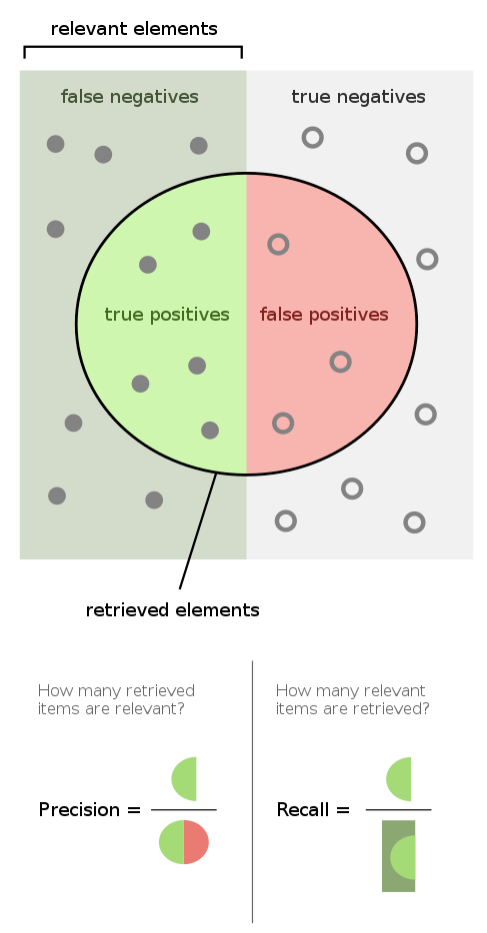

https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers

In [ ]:
print(confusion_matrix(y_true=data_HW_mod.survived, y_pred=data_HW_mod.predict))

In [ ]:
print(classification_report(y_true=data_HW_mod.survived, y_pred=data_HW_mod.predict))

In [ ]:
sns.histplot(data=data_HW_mod, x='fitted', hue='survived', alpha=0.2, fill=True, stat='density', kde=True,
            binwidth=0.05)
plt.show()

sns.histplot(data=data_HW_mod, x='fitted', hue='sex', alpha=0.5, fill=True, stat='count', binwidth=0.05)
plt.show()

In [ ]:
data_HW_mod = data_HW_mod >> \
        mutate(
               predict_04 = np.where(mod_1.fittedvalues.to_numpy() > 0.4, '1', '0'),
              )
data_HW_mod['predict_04'] = data_HW_mod['predict_04'].astype('category')

print(data_HW_mod.head())
print(print(confusion_matrix(y_true=data_HW_mod.survived, y_pred=data_HW_mod.predict_04)))

In [ ]:
(392+265)/(392 + 265 + 104+ 73 ) # Accuracy from Confusion Matrix

## Use test data

In [ ]:
titanic_test.head()

In [ ]:
data_test = titanic_test[['age', 'sex', 'pclass', 'fare', 'embarked']] >> \
            filter_by(titanic_test.embarked.isin(('C', 'S', 'Q')) )  >> \
            transmute(survived = titanic_test.survived,
                      survived_num = titanic_test.survived.astype('float'),
                      age = pd.cut(titanic_test.age,(-np.inf, 16, np.inf), labels=["child","adult"]),
                      age_num = titanic_test.age,
                      fare = titanic_test.fare,
                      fare_quantile = pd.qcut(titanic_test.fare, q=8, labels=list(range(1, 9))),
                      fare_quantile2 = pd.qcut(titanic_test.fare, q=np.linspace(0, 1, 9)),
                      class_ = titanic_test.pclass.astype('category'),
                      sex = titanic_test.sex.astype('category'),
                      embarked = titanic_test.embarked.astype('category'))

data_test = data_test.dropna(axis=0, how='any')  # `axis=0` stands for per index (row)
print(data_test.describe(include='all'))
print(data_test.info())
#data_test.head()

In [ ]:
# Compute predictions for the test set
data_test_mod = data_test.copy()
data_test_mod['fitted'] = mod_1.predict(data_test_mod)
data_test_mod['predict'] = np.where(data_test_mod['fitted'] > 0.5, '1', '0')
data_test_mod['predict'] = data_test_mod['predict'].astype('category')
data_test_mod['r_deviance_std'] = np.nan  # not available for out-of-sample
data_test_mod['r_pearson_std'] = np.nan   # not available for out-of-sample
data_test_mod['source'] = 'test'

# Add source column to training set
data_HW_mod['source'] = 'train'

# Combine into one dataframe
data_combined = pd.concat([data_HW_mod, data_test_mod], axis=0)

# Split by dataset (train/test)
sns.histplot(data=data_combined, x='fitted', hue='source',
             element='step', common_norm=False, stat='density', bins=15)
plt.title("Predicted probability distributions by dataset")
plt.show()



In [ ]:
g = sns.FacetGrid(data_combined, col='source', hue='survived', height=4, aspect=1.2)
g.map(sns.histplot, 'fitted', stat='density', element='step', bins=30)
g.add_legend()
g.set_titles("Dataset: {col_name}")
plt.suptitle("Fitted Value Distributions by Class and Dataset", y=1.05)
plt.tight_layout()
plt.show()


In [ ]:
# Create a combined label for hue
data_combined['source_survived'] = data_combined['source'].astype(str) + "_y" + data_combined['survived'].astype(str)
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(
    data=data_combined,
    x='fitted',
    hue='source_survived',
    multiple='layer',
    stat='density',
    bins=20,
    palette='Set1',
    alpha=0.3,
    element='step'
)

# KDE (smoothed version)
sns.kdeplot(
    data=data_combined,
    x='fitted',
    hue='source_survived',
    common_norm=False,
    palette='Set1',
    lw=2
)

plt.title("Predicted Probability Distributions by Dataset and True Class")
plt.xlabel("Fitted Probability (Survival)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
data_test = data_test >> \
        mutate(fitted=mod_1.predict(exog = data_test, linear=False),
               predict = np.where(mod_1.predict(exog = data_test, linear=False).to_numpy() > 0.5, '1', '0')
              ) >> \
        arrange(data_test.age_num)

data_test['predict'] = data_test['predict'].astype('category')
print(data_test.head())

fig, ax = plt.subplots()
sns.lineplot(data=data_test, x='age_num', y='fitted', hue=data_test[['sex', 'class_']].apply(tuple, axis=1), ax=ax)
sns.rugplot(data=data_test, x='age_num', y='survived_num', hue='survived', ax=ax)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')
fig.legend(loc='center right')


plt.show()

In [ ]:
data_test_select = data_test[(data_test.sex == 'male') & (data_test.class_ == 2)]

fig, ax = plt.subplots()
sns.lineplot(data=data_test_select, x='age_num', y='fitted', ax=ax, color='green')
sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')

plt.show()

In [ ]:
print(mod_1.summary())

In [ ]:
# unfortunately there is not such parameter to calculate `se.fit` so we need perform calculation by hand
# se_fit for linear predictor not for mu
se_fit = []
for _, row in data_test_select[['age_num']].iterrows():
    vec = np.array([1, 1, 1, 0, row['age_num']])
    se_fit.append(np.sqrt(vec @ mod_1.cov_params().to_numpy() @ vec.T))
se_fit = np.array(se_fit)


### Wrong way to plot confidence interval (student solution from couple of years ago)

In [ ]:
## Add standard errors and compute a 95% interval the wrong way

# se for nonlinear fit ??
se_fit_w = np.sqrt(mod_1.model.family.variance(mod_1.predict(data_test_select, linear=False)))

data_test_select = data_test_select >> \
  mutate(wrong_se = se_fit_w, #se_fit,
         wrong_upr = data_test_select.fitted + (2 * se_fit_w),
         wrong_lwr = data_test_select.fitted - (2 * se_fit_w))

fig, ax = plt.subplots()
sns.lineplot(data=data_test_select, x='age_num', y='fitted', ax=ax, color='green')
#sns.lineplot(x='age_num', y='wrong_upr', data=data_test_select, ax=ax, color='purple', markers=['-*'])
#sns.lineplot(x='age_num', y='wrong_lwr', data=data_test_select, ax=ax, color='purple', markers=['-*'])
sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

#ax.lines[1].set_linestyle("--")
#ax.lines[2].set_linestyle("--")

plt.fill_between(
        x= data_test_select.age_num,
        y1= data_test_select.wrong_upr,
        y2 =data_test_select.wrong_lwr,
        color= "purple",
        alpha= 0.1)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')

plt.show()

## The Right way

In [ ]:
se_fit  # for linear predictor

In [ ]:
# Use inverse link function (logit -> probability)
ilink = mod_1.model.family.link.inverse

quant_t = scipy.stats.t.isf(0.025, df =mod_1.df_resid)
quant_n = scipy.stats.norm.isf(0.005)

data_test_select = data_test_select >> \
   mutate(fit_link = mod_1.predict(data_test_select, linear=True),
          se_link  = se_fit,
          fit  = ilink(mod_1.predict(data_test_select, linear=True)),
          fit_ul = ilink(mod_1.predict(data_test_select, linear=True) + (quant_n * se_fit)),
          fit_ll = ilink(mod_1.predict(data_test_select, linear=True) - (quant_n * se_fit)))
## show
print(data_test_select.head())

fig, ax = plt.subplots()
sns.lineplot(data=data_test_select, x='age_num', y='fitted', ax=ax, color='green')
#sns.lineplot(x='age_num', y='fit_ul', data=data_test_select, ax=ax, color='purple', markers=['-*'])
#sns.lineplot(x='age_num', y='fit_ll', data=data_test_select, ax=ax, color='purple', markers=['-*'])
sns.rugplot(data=data_test_select, x='age_num', y='survived_num', hue='survived', ax=ax)

#ax.lines[1].set_linestyle("--")
#ax.lines[2].set_linestyle("--")
plt.fill_between(
        x= data_test_select.age_num,
        y1= data_test_select.fit_ul,
        y2 =data_test_select.fit_ll,
        color= "purple",
        alpha= 0.1)


ax.set_xlabel('Age')
ax.set_ylabel('Probability of survival')


plt.show()


In [ ]:
# Generated solution

# Prepare sorted test data for smoother plots
data_test_select_sorted = data_test_select.sort_values('age_num')

# Get prediction and confidence intervals on the link scale
predictions = mod_1.get_prediction(data_test_select_sorted)
pred_summary = predictions.summary_frame()

data_test_select_sorted['fitted'] = ilink(pred_summary['mean'])
data_test_select_sorted['fit_ll'] = ilink(pred_summary['mean_ci_lower'])
data_test_select_sorted['fit_ul'] = ilink(pred_summary['mean_ci_upper'])

# Plot correctly transformed values
fig, ax = plt.subplots(figsize=(10, 6))

# Predicted probabilities and CI bands
sns.lineplot(x='age_num', y='fitted', data=data_test_select_sorted, color='green', ax=ax)
ax.fill_between(
    data_test_select_sorted['age_num'],
    data_test_select_sorted['fit_ll'],
    data_test_select_sorted['fit_ul'],
    color='purple', alpha=0.2, label='95% CI'
)

# Rug plot for actual data points by survival
sns.rugplot(x='age_num', hue='survived', data=data_test_select_sorted, ax=ax)

ax.set_xlabel('Age')
ax.set_ylabel('Probability of Survival')
ax.legend()

plt.tight_layout()
plt.show()


Why both plots differ?

### Binary classification & ROC curves

https://en.wikipedia.org/wiki/Binary_classification

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

https://en.wikipedia.org/wiki/Receiver_operating_characteristic



Python resources

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



In [ ]:
fpr, tpr, thresholds = roc_curve(data_HW_mod.survived_num, data_HW_mod.fitted)
auc = roc_auc_score(data_HW_mod.survived_num, data_HW_mod.fitted)  # auc

plt.plot(fpr,tpr,label=f"AUC={round(auc, 2)}")
plt.ylabel('True Positive Rate')  # aka sensitivity
plt.xlabel('False Positive Rate') # aka 1-specificity
plt.legend(loc=4)
plt.show()

In [ ]:
where = np.where((fpr > 0.0) & (fpr <= 0.1))[0]
pAUC = np.trapz(tpr[where], fpr[where], dx=0.01)  # 0.0-0.1 FPR
where2 = np.where((tpr > 0.9) & (tpr <= 1))[0]
pAUC2 = np.trapz(tpr[where2]-tpr[where2].min(), fpr[where2], dx=0.01)  # 0.9-1 TPR


In [ ]:

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')  # aka sensitivity
plt.xlabel('False Positive Rate') # aka 1-specificity

plt.fill_between(
        x= fpr[where2],
        y1= tpr[where2],
        y2 =tpr[where2].min(),
        color= "green",
        label=f'pAUC (0.9-1 TPR) \n {round(pAUC2, 2)}',  # partial auc
        alpha= 0.5)
plt.fill_between(
        x= fpr[where],
        y1= tpr[where],
        label=f'pAUC (0-0.1 FPR) \n {round(pAUC, 2)}',   # partial auc
        color= "purple",
        alpha= 0.5)
plt.legend(loc=4)
plt.show()

## Your Turn :

* Compute a new variable `nrelatives = sibsp + parch`
* Fit model with this new variable (you can try use it as continuous or as factor (change levels)) and `sex, age, fare, class, embarked`
* Try to use `step` function to find the "best" model.
* Validate the model. Are all variables significant? If you have any numerical variable, does it need any transformation?
* Plot densities of fitted probabilities for survived/not survived and choose optimal threshold.
* Compute the confusion matrix and basic statistics and compare results of your model with model mod_1
* Plot ROC curve of your model together with ROC curve of mod_1. Which one has larger AUC.

* Calibrate the output and show if its calibrated. Compare results with RF from scikit-learn

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve,
                             roc_auc_score, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

!pip install dfply  # install first, then comment out
from dfply import *

In [ ]:
titanic = datasets.fetch_openml("titanic", version=1, as_frame=True).frame


num_vars = ["age", "fare", "sex", "pclass", "embarked"]
cat_hue  = "survived"

titanic[cat_hue] = titanic[cat_hue].astype("category")

plot_df = titanic[num_vars + [cat_hue]].dropna()

sns.set_theme(style="ticks", context="notebook")
g = sns.pairplot(plot_df, vars=num_vars, hue=cat_hue,
                 diag_kind="hist", palette="Set2", corner=True)
g.fig.suptitle("Titanic dataset – pairwise relationships", y=1.02)
plt.show()

#### <u>Describing the data</u>
- **fare** is extremely right skewed + few 'ouliers', will try to use log()
- **age** will be transformed into child/adult dummies
- **pclass** will be treated as a factor class
- **sex** has good separation, leaving it as a factor var
- **embarked** ok

In [ ]:
# Load
titanic = datasets.fetch_openml("titanic", version=1, as_frame=True).frame
data = titanic[["survived", "age", "fare", "pclass", "sex", "embarked"]].copy()

# Categorical columns
for col in ["survived", "pclass", "sex", "embarked"]:
    data[col] = data[col].astype("category")

data["age_cont"] = data["age"]
data = data[data["embarked"].isin(["C", "S", "Q"])].copy()

data["survived_num"] = data["survived"].astype(float)

# Age
data["age_cat"]  = pd.cut(data["age"], (-np.inf, 16, np.inf),
                          labels=["child", "adult"])
data["age_num"]  = (data["age_cat"] == "adult").astype(int)
data["age_cont"] = data["age"]  #  numeric

# Log-fare
data["log_fare"] = np.log1p(data["fare"])

# NaNs
data = data.dropna(subset=["age", "fare", "pclass", "sex", "embarked"]).copy()

# New var
data["nrelatives"] = titanic.loc[data.index, "sibsp"] + titanic.loc[data.index, "parch"]
bins   = [-.1, .5, 1.5, 2.5, 3.5, 10.1]
labels = ["0","1","2","3","4+"]
data["nrelatives_bin"] = pd.cut(data["nrelatives"], bins=bins, labels=labels,
                                ordered=True).astype("category")

data["nrel4"] = pd.cut(
    data["nrelatives"],
    bins=[-1, 0, 1, 2, data["nrelatives"].max()],
    labels=["0","1","2","3+"],
    ordered=True
).astype("category")



## Fiting a model with the new variable
- continuous
- categorical

In [ ]:
# Continuous
fml_cont = (
    "survived_num ~ nrelatives + I(nrelatives**2) + age_num + age_cont + log_fare + C(sex) "
    "+ C(pclass) + C(embarked)"
)
mod_cont = smf.glm(formula=fml_cont, data=data,
                   family=sm.families.Binomial()).fit()
print(mod_cont.summary())
print(f"AIC of continuous version: {mod_cont.aic}")

# Categorical
fml_cat = ("survived_num ~ C(nrelatives_bin) + "
            "age_num + age_cont + log_fare + "
            "C(sex) + C(pclass) + C(embarked)")

mod_cat = smf.glm(formula=fml_cat, data=data,
                  family=sm.families.Binomial()).fit()
print(mod_cat.summary())
print(f"AIC of categorical version: {mod_cat.aic}")

We can see that the bigger families are slightly disadvantaged.

## <u>Best model selection</u>
### Huraaayy to R

In [ ]:
!pip install -q -U rpy2

# Magic
%load_ext rpy2.ipython

In [ ]:
data_r = data.copy()
for c in data_r.select_dtypes(['category']).columns:
    data_r[c] = data_r[c].astype(str)
%R -i data_r

#### **Continuous and Categorical model**

In [ ]:
%%R
library(MASS)
df <- data_r

# Factors
factor_cols <- c("sex", "pclass", "embarked", "nrelatives_bin")
df[factor_cols] <- lapply(df[factor_cols], as.factor)

# ontinuous nrelatives
full_cont <- glm(
  survived_num ~ nrelatives + I(nrelatives^2)
                + age_cont + age_num
                + log_fare             # or `fare` if you didn't log-transform
                + sex + pclass + embarked,
  data = df, family = binomial()
)

best_cont <- step(
  full_cont,
  scope = list(lower = ~1, upper = formula(full_cont)),
  direction = "both",
  trace = 0
)
cat("\n=== Continuous relatives model ===\n")
print(summary(best_cont))


# Binned nrelatives
full_bin <- glm(
  survived_num ~ C(nrelatives_bin)
                + age_cont + age_num
                + log_fare            # keep consistent
                + sex + pclass + embarked,
  data = df, family = binomial()
)

best_bin <- step(
  full_bin,
  scope = list(lower = ~1, upper = formula(full_bin)),
  direction = "both",
  trace = 0
)
cat("\n=== Binned relatives model ===\n")
print(summary(best_bin))


#### Little comparison
Comparing if including nrelatives in the first model is actually ok

In [ ]:
%%R
m_full <- glm(survived_num ~ nrelatives + I(nrelatives^2) + age_cont + age_num
              + sex + pclass + embarked, data=df, family=binomial)
m_nolim <- update(m_full, . ~ . - nrelatives)

anova(m_nolim, m_full, test="Chisq")

Linear term is not statistically significant at 0.05 level, improvement in deviance is small.

**Dropping the nrelatives term!**

In [ ]:
# %%R

# max_fml <- survived_num ~
#    (nrelatives +  age_num
#     + log(fare+1)
#     + sex + pclass + embarked)^2

# full_mod <- glm(max_fml, data=df, family=binomial())
# best_mod <- step(full_mod, direction="both", trace=1,
#                  scope=list(upper=full_mod, lower=~1))
# summary(best_mod)

### Back to Python!

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Continuous
fml_cont = (
    "survived_num ~ I(nrelatives**2) "
    "+ age_cont + age_num "
    "+ C(sex) + C(pclass) + C(embarked)"
)
mod_cont = smf.glm(formula=fml_cont, data=data,
                   family=sm.families.Binomial()).fit()
print(mod_cont.summary())
print("AIC (continuous):", mod_cont.aic)

# Binned
fml_cat = (
    "survived_num ~ C(nrelatives_bin) "
    "+ age_cont + age_num "
    "+ C(sex) + C(pclass) + C(embarked)"
)
mod_cat = smf.glm(formula=fml_cat, data=data,
                     family=sm.families.Binomial()).fit()
print(mod_cat.summary())
print("AIC (binned):", mod_cat.aic)


# <u>Model validation</u>

#### Using the helper file

In [ ]:
!pip install wget
import wget
url = "https://github.com/francji1/01ZLMA/raw/main/code/helpers.py"
wget.download(url, '../content/helpers.py')

#### For Continuous model

In [ ]:
from helpers import DiagnosticPlots, Anova

cls = DiagnosticPlots(mod_cont) # init
cls(plot_context='seaborn-v0_8')


# Does nrelatives improve fit?
mod_nested = smf.glm(
    "survived_num ~ age_cont + age_num + C(sex) + C(pclass) + C(embarked)",
    data=data, family=sm.families.Binomial()).fit()
print(Anova()(mod_nested, mod_cont, test='chisq'))

Very low p-value, improves the deviance, nrelatives belongs in the model

#### For Categorical model

In [ ]:
from helpers import DiagnosticPlots, Anova

cls = DiagnosticPlots(mod_cat) # init
cls(plot_context='seaborn-v0_8')


# Does nrelatives improve fit?
mod_nested = smf.glm(
    "survived_num ~ age_cont + age_num + C(sex) + C(pclass) + C(embarked)",
    data=data, family=sm.families.Binomial()).fit()
print(Anova()(mod_nested, mod_cont, test='chisq'))

Very low p-value, improves the deviance, binned nrelatives belongs in the model

#### Working responses

Below function was **generated** by ChatGPT.

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
sns.set_theme()

def link_diagnostics(glm_res, data, formula_rhs):
    """
    Link-function diagnostic for a statsmodels GLMResults object.

    1) Plots the working response z versus the linear predictor η.
    2) Runs the Pregibon link test (adds η² term) and reports its p-value.

    Parameters
    ----------
    glm_res : statsmodels.genmod.generalized_linear_model.GLMSResults
        A fitted GLMResults (e.g. from smf.glm(...).fit()).
    data : pandas.DataFrame
        The original DataFrame used to fit the model; must contain the response column.
    formula_rhs : str
        The right-hand side of the model formula (everything after the "~"),
        excluding the response. Used to construct the Pregibon test formula.
    """
    # 1) compute η and μ
    # ──────────────────────────────────────────────────────────────────────────
    # linear predictor
    eta = glm_res.predict(linear=True)
    # fitted mean on original scale
    mu  = glm_res.predict()

    # 2) compute dμ/dη for the model’s link
    # ──────────────────────────────────────────────────────────────────────────
    link = glm_res.family.link

    if isinstance(link, sm.families.links.logit):
        # logistic: μ = exp(η)/(1+exp(η)), dμ/dη = μ(1−μ)
        dmu_deta = mu * (1 - mu)

    elif isinstance(link, sm.families.links.probit):
        # probit: μ = Φ(η), dμ/dη = φ(η)  (standard normal pdf at η)
        from scipy.stats import norm
        dmu_deta = norm.pdf(eta)

    elif isinstance(link, sm.families.links.cloglog):
        # clog-log: μ = 1 − exp(−exp(η)), dμ/dη = exp(η) * exp(−exp(η))
        dmu_deta = np.exp(eta) * np.exp(-np.exp(eta))

    else:
        # numeric fallback: central difference on the inverse link
        inv_link = link.inverse
        eps = 1e-6
        dmu_deta = (inv_link(eta + eps) - inv_link(eta - eps)) / (2 * eps)

    # 3) working response z = η + (y−μ)/μ′
    # ──────────────────────────────────────────────────────────────────────────
    y = data[glm_res.model.endog_names]
    z = eta + (y - mu) / dmu_deta

    # 4) plot z vs η
    # ──────────────────────────────────────────────────────────────────────────
    plt.figure(figsize=(6,6))
    plt.scatter(eta, z, alpha=0.4)
    sns.regplot(x=eta, y=z, lowess=True, scatter=False, color="red")
    mn, mx = np.nanmin(eta), np.nanmax(eta)
    plt.plot([mn, mx], [mn, mx], "--", color="gray", linewidth=1)
    plt.xlabel("Linear predictor $\eta$")
    plt.ylabel("Working response $z$")
    plt.title("Working response vs linear predictor\n(link-function check)")
    plt.grid(True)
    plt.show()

    # 5) Pregibon link test: add η² to the model
    # ──────────────────────────────────────────────────────────────────────────
    df = data.copy()
    df["_eta"]  = eta
    df["_eta2"] = eta**2

    preg_formula = f"{glm_res.model.endog_names} ~ {formula_rhs} + _eta2"
    preg_mod = sm.GLM.from_formula(preg_formula, data=df,
                                   family=glm_res.family).fit()

    pval = preg_mod.pvalues["_eta2"]
    print(f"Pregibon test p(_eta²) = {pval:.4g}")
    if pval < 0.05:
        print("⇒ reject null: link may be misspecified.")
    else:
        print("⇒ no evidence against the chosen link.")


rhs = "I(nrelatives**2) + age_cont + age_num + C(sex) + C(pclass) + C(embarked)"
link_diagnostics(mod_cont, data, rhs)

#### **Trying a different link**: <u>CLogLog</u>


In [ ]:
from statsmodels.genmod.families.links import CLogLog

# continuous
fml_cont = (
    "survived_num ~ I(nrelatives**2) "
    "+ age_cont + age_num "
    "+ C(sex) + C(pclass) + C(embarked)"
)

# fit with cloglog link
mod_clog = smf.glm(
    formula=fml_cont,
    data=data,
    family=sm.families.Binomial(link=CLogLog())
).fit()

print(mod_clog.summary())
print("AIC (clog-log):", mod_clog.aic)
print("AIC (logit)  :", mod_cont.aic)

In [ ]:
link_diagnostics(mod_clog, data, rhs)

This is actually much better, but i will still stick to logit for interpretability.

# Density of fitted probabilities

### PDF of fitted and Confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, classification_report,
    ConfusionMatrixDisplay, roc_auc_score
)

sns.set_theme()

def evaluate_model(model, data, name="model"):
    # predicted probabilities
    data = data.copy()
    data["prob"] = model.predict(data)

    # density plot
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=data, x="prob", hue="survived",
                common_norm=False, fill=True)
    plt.title(f"{name} — predicted‐prob densities")
    plt.xlabel("predicted probability")
    plt.show()

    # Youdens J threshold
    fpr, tpr, thr = roc_curve(data.survived_num, data.prob)
    opt = thr[np.argmax(tpr - fpr)]
    print(f"{name}  → chosen threshold = {opt:.3f}")

    # confusion matrix & report
    y_pred = (data.prob >= opt).astype(int)
    disp = ConfusionMatrixDisplay.from_predictions(
        data.survived_num, y_pred, cmap="Blues"
    )
    disp.ax_.set_title(f"{name} @ thr {opt:.3f}")
    plt.show()
    print(classification_report(data.survived_num, y_pred, digits=3))

    # AUC
    auc = roc_auc_score(data.survived_num, data.prob)
    print(f"{name}  → AUC = {auc:.3f}\n")
    return opt, auc

# Continuous
opt_cont, auc_cont = evaluate_model(
    mod_cont, data, name="Continuous‐relatives GLM"
)


In [ ]:
# Binned
opt_bin, auc_bin = evaluate_model(
    mod_cat, data, name="Binned‐relatives GLM"
)

### ROC curves and AUC

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve

# true labels
y_true = data["survived_num"]

# predicted scores from your two models
y_cont = mod_cont.predict(data)
y_bin  = mod_cat.predict(data)

# compute AUCs
auc_cont = roc_auc_score(y_true, y_cont)
auc_bin  = roc_auc_score(y_true, y_bin)
print(f"AUC (continuous relatives) = {auc_cont:.3f}")
print(f"AUC (binned relatives)     = {auc_bin:.3f}")

# plot both ROC curves
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(
    y_true, y_cont,
    name="Continuous",
    ax=ax
)
RocCurveDisplay.from_predictions(
    y_true, y_bin,
    name="Categorical",
    ax=ax
)

# random reference
ax.plot([0,1], [0,1], "--", color="gray", linewidth=1)
ax.set_title("ROC Curves: Continuous vs Binned Relatives")
ax.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier

train, test = train_test_split(
    data,
    test_size=0.20,
    stratify=data.survived_num,
    random_state=42
)

# fit best GLM
fml_best = (
    "survived_num ~ C(nrelatives_bin) + age_cont + age_num "
    "+ C(sex) + C(pclass) + C(embarked)"
)
best_tr = smf.glm(
    fml_best,
    data=train,
    family=sm.families.Binomial(link=sm.families.links.logit())
).fit()

# predict
test = test.copy()
test["prob_glm"] = best_tr.predict(test)

# threshold
fpr, tpr, thr = roc_curve(test.survived_num, test.prob_glm)
opt_thr = thr[np.argmax(tpr - fpr)]

# confusion matrix + class
y_pred = (test.prob_glm >= opt_thr).astype(int)

# ROC & AUC for GLM
fpr_rf, tpr_rf, _ = roc_curve(test.survived_num, test.prob_glm)

# Random Forest benchmark
features = ["nrelatives", "age_cont", "age_num", "log_fare"]
X_train = pd.get_dummies(train[features + ["sex","pclass","embarked"]], drop_first=True)
y_train = train.survived_num
X_test  = pd.get_dummies(test[features + ["sex","pclass","embarked"]], drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)
y_test  = test.survived_num

rf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
test["prob_rf"] = rf.predict_proba(X_test)[:,1]

# ROC & AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, test.prob_rf)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix for GLM
ConfusionMatrixDisplay.from_predictions(test.survived_num, y_pred, ax=axes[0])
axes[0].set_title(f"GLM @ thr {opt_thr:.2f}")

# ROC Curve: GLM vs RF
sns.lineplot(x=fpr, y=tpr, ax=axes[1], label=f"GLM (AUC={roc_auc_score(test.survived_num, test.prob_glm):.3f})")
sns.lineplot(x=fpr_rf, y=tpr_rf, ax=axes[1], label=f"RF (AUC={roc_auc_score(y_test, test.prob_rf):.3f})")
axes[1].plot([0, 1], [0, 1], "--", color="gray")
axes[1].set_xlabel("False positive rate")
axes[1].set_ylabel("True positive rate")
axes[1].set_title("ROC: GLM vs RF")
axes[1].legend()

# Calibration Curve for GLM
CalibrationDisplay.from_predictions(test.survived_num, test.prob_glm, n_bins=8, ax=axes[2])
CalibrationDisplay.from_predictions(y_test, test.prob_rf, n_bins=8, ax=axes[2])
axes[2].set_title("Calibration: GLM vs RF")

# Show all plots
plt.tight_layout()
plt.show()

# Print classification reports and Brier scores
print("GLM classification report:")
print(classification_report(test.survived_num, y_pred, digits=3))
print("GLM Brier score:", brier_score_loss(test.survived_num, test.prob_glm))

print("RF Brier score:", brier_score_loss(y_test, test.prob_rf))